Welcome to Voxelmap!

The first thing we'll do is train the neural network (Network A). We'll then test the network to see how it performs.

# Imports


## Imports and Setup

This cell initializes the core libraries required for the experiment.

- Standard Python utilities for timing, file system access, and numerical computation
- PyTorch for deep learning, optimization, and dataset handling
- Matplotlib for visualization
- Project-specific modules for network definitions and loss functions
- Warning suppression to keep notebook output clean

These imports form the foundation for model training, evaluation, and result analysis in subsequent cells.


In [1]:
# imports
import time
import os
import numpy as np
from matplotlib import pyplot as plt
from utilities import network_a, losses
import torch
from torch.utils.data import Dataset
import torch.optim as optim
import warnings
import random
warnings.filterwarnings("ignore")


# File Names

## Experiment Configuration

This cell defines the experiment metadata and dataset configuration.

- Specifies patient identifier, treatment day, and dataset type
- Selects scatter or no-scatter data (Scatter is added in Treatment day 2 Dataset)
- Constructs the input image directory based on the chosen configuration
- Defines experiment description and output filename for logging and checkpoints

This configuration block ensures consistency and reproducibility across training runs.


In [2]:
random.seed(42)

In [3]:
import os

Patient_number = "P2"
NoScatter = True
Scatter = False
DatasetType="SPARE"
DayofTreatment = 1
NetworkType="A"

if NoScatter == Scatter:
    raise ValueError("Set exactly one of NoScatter or Scatter to True.")

scatter_tag = "NS" if NoScatter else "SC"

im_dir = os.path.join(
    "/srv/shared/SPARE", # Will Change Based on Your Folder
    f"MC_V_{Patient_number}_{scatter_tag}_{DayofTreatment:02d}"
)

expt_description = f"Network_{NetworkType}_{DatasetType}_{Patient_number}"
filename = f"Train_Network_{NetworkType}_{DatasetType}_{Patient_number}"

print("im_dir =", im_dir)


im_dir = /srv/shared/SPARE/MC_V_P2_NS_01


# Setup Dataset

## Supervised Dataset Definition

This cell defines a custom PyTorch `Dataset` for supervised training.

- Loads source and target projections, volumes, and deformation vector fields (DVFs) from disk
- Applies min–max normalization to projection and volume data
- Constructs source–target pairs based on filename conventions
- Reshapes data into channel-first tensors compatible with PyTorch models
- Returns a dictionary containing all inputs and ground truth required for training

This dataset class standardizes data access and preprocessing for the training pipeline.


In [4]:
# set up training dataset class
class SupervisedDataset(Dataset):
    def __init__(self, im_dir=None, im_size=None):
        self.im_dir = im_dir
        self.im_size = im_size

    def __len__(self):
        return len([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy')])

    def __getitem__(self, idx):
        # Find target projection
        proj_list = sorted([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy')])
        target_file = proj_list[idx]
        proj_name = os.path.join(self.im_dir, format(target_file))
        target_proj = np.load(proj_name)
        target_proj = (target_proj - np.min(target_proj)) / (np.max(target_proj) - np.min(target_proj))

        # Find target DVF
        vol_num = target_file[:2]
        dvf_name = os.path.join(self.im_dir, format('DVF_' + vol_num + '_mha.npy'))
        target_dvf = np.load(dvf_name)

        # Find source projection
        source_file = '06_' + target_file[3:]
        proj_name = os.path.join(self.im_dir, format(source_file))
        source_proj = np.load(proj_name)
        source_proj = (source_proj - np.min(source_proj)) / (np.max(source_proj) - np.min(source_proj))

        # Find source volume
        vol_name = os.path.join(self.im_dir, format('subCT_06_mha.npy'))
        source_vol = np.load(vol_name)
        source_vol = (source_vol - np.min(source_vol)) / (np.max(source_vol) - np.min(source_vol))

        # Find source abdomen
        vol_name = os.path.join(self.im_dir, format('sub_Abdomen_mha.npy'))
        source_hull = np.load(vol_name)

        # Reshape data
        source_projections = np.zeros((1, self.im_size, self.im_size), dtype=np.float32)
        source_projections[0, :, :] = np.asarray(source_proj)
        target_projections = np.zeros((1, self.im_size, self.im_size), dtype=np.float32)
        target_projections[0, :, :] = np.asarray(target_proj)

        source_volumes = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        source_volumes[0, :, :, :] = np.asarray(source_vol)
        source_abdomen = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        source_abdomen[0, :, :, :] = np.asarray(source_hull)

        target_flow = np.zeros((3, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        target_flow[0, :, :, :] = target_dvf[:, :, :, 0]
        target_flow[1, :, :, :] = target_dvf[:, :, :, 1]
        target_flow[2, :, :, :] = target_dvf[:, :, :, 2]

        data = {'source_projections': torch.from_numpy(source_projections),
                'target_projections': torch.from_numpy(target_projections),
                'source_volumes': torch.from_numpy(source_volumes),
                'source_abdomen': torch.from_numpy(source_abdomen),
                'target_flow': torch.from_numpy(target_flow)}

        return data

Lookin' good! Now we will create training and validation datasets

## Data Loading and Visualization

This cell creates a test data loader and retrieves a single example from the dataset.

- Initializes the dataset and `DataLoader` with batch size 1
- Extracts source projections, target projections, volumes, abdomen mask, and DVF
- Visualizes:
  - The source projection
  - A central axial slice from the source volume
  - A mid-slice component of the target deformation vector field (DVF)

This step provides a quick sanity check to verify data integrity, orientation, and alignment before training.


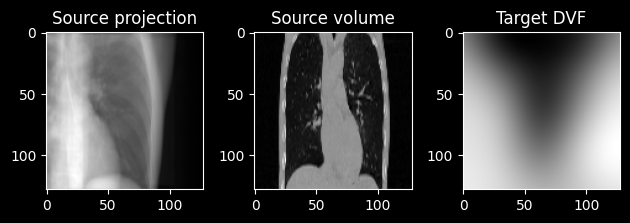

In [5]:
# Generate test loader
batch_size = 1
im_size = 128
exampleset = SupervisedDataset(im_dir=im_dir, im_size=im_size)
exampleloader = torch.utils.data.DataLoader(exampleset, batch_size=batch_size)
data = next(iter(exampleloader))

source_proj, target_proj, source_vol, source_abdomen, target_flow = data['source_projections'], \
                                                                                        data['target_projections'], \
                                                                                        data['source_volumes'], \
                                                                                        data['source_abdomen'], \
                                                                                        data['target_flow']
# visualise projection, volume and DVF
f = plt.figure()
plt.subplot(1,3,1)
source_proj = np.squeeze(source_proj)
plt.imshow(source_proj, cmap='gray')
plt.title('Source projection')

plt.subplot(1,3,2)
source_vol = np.squeeze(source_vol)
plt.imshow(np.transpose(source_vol[:,:, int(source_vol.shape[2] / 2)]), cmap='gray')
plt.title('Source volume')

plt.subplot(1,3,3)
target_flow = np.squeeze(target_flow)
plt.imshow(np.flipud(np.transpose(target_flow[1,:,:, int(source_vol.shape[2] / 2)])), cmap='gray')
plt.title('Target DVF')

f.tight_layout()
plt.show()

Network time! Let's set up a cuda implementation of the network, a loss function (good ol' MSE will do! but we're computing it within a thoracoabdominal mask) and an optimizer

In [6]:
import numpy as np

def get_numpy_similarity(path1, path2):
    # 1. Load the numpy arrays
    arr1 = np.load(path1)
    arr2 = np.load(path2)

    # 2. Flatten the arrays to 1D vectors
    # This works regardless of shape (e.g., 128x128x128 or 3x128x128x128)
    vec1 = arr1.flatten()
    vec2 = arr2.flatten()

    # 3. Calculate Dot Product
    dot_product = np.dot(vec1, vec2)

    # 4. Calculate Norms (Magnitudes)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)

    # 5. Compute Cosine Similarity
    # We add a tiny epsilon (1e-9) to avoid division by zero
    similarity = dot_product / (norm1 * norm2 + 1e-9)

    return similarity

# Usage
file_a = im_dir + "/06_Proj_00064_bin.npy"
file_b = "/srv/shared/SPARE/MC_V_P2_SC_02/"+ "source/06_Proj_00064_bin.npy"
score = get_numpy_similarity(file_a, file_b)
print(f"Cosine Similarity: {score:.6f}")

Cosine Similarity: 0.995928


It's important to note that , this difference is because there could have been changes to the anatomy between planning and treatment day.

# Training

## Training Setup

This cell prepares the data split, model, and optimization components for training.

- Splits the dataset into training and validation sets using a 90/10 ratio
- Creates shuffled data loaders for efficient batch processing
- Initializes the network architecture with the specified image size and integration steps
- Configures the computation device for GPU or CPU execution
- Defines the flow-based loss function and Adam optimizer with a fixed learning rate

This setup establishes all core elements required to begin model training.

In [7]:
# generate train/test split
im_size = 128
batch_size = 8
dataset = SupervisedDataset(im_dir=im_dir, im_size=im_size)
split = [int(len(dataset) * 0.9), int(len(dataset) * 0.1)]
trainset, valset = torch.utils.data.dataset.random_split(dataset, split)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

In [8]:

import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt

from continue_training import (
    save_checkpoint,
    load_checkpoint_if_available,
    plot_losses,
)

# ---- device  ----
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ---- set up network  ----
model = network_a.model(im_size, int_steps=10).to(device)

# ---- loss + optimizer ----
flow_mask = losses.flow_mask()
lr = 1e-5
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
# =========================
# TRAIN (supports resume)
# =========================


print('Training (on ' + str(device) + ')...')
tic = time.time()

# IMPORTANT:
# epoch_num is the TOTAL epoch you want to reach.
# If you trained to 50 and want to continue to 100, set epoch_num = 100.
epoch_num = 50

save_dir = f"{DatasetType}_{NetworkType}_{Patient_number}_weights"
plot_dir = f"{DatasetType}_{NetworkType}_{Patient_number}_plots"
os.makedirs(save_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)
# ---- resume (loads model+optimizer+history if checkpoint exists) ----
ckpt_path = os.path.join(save_dir, f"{DatasetType}_{NetworkType}_{Patient_number}_ckpt.pth")
start_epoch, min_val_loss, train_losses, val_losses = load_checkpoint_if_available(
    ckpt_path=ckpt_path,
    model=model,
    optimizer=optimizer,
    device=device,
)

print(f"Starting at epoch {start_epoch} (target total: {epoch_num})")

# ---- training loop ----
for epoch in range(start_epoch, epoch_num + 1):
    model.train()
    train_loss = 0.0

    for data in trainloader:
        source_proj = data['source_projections'].to(device)
        target_proj = data['target_projections'].to(device)
        source_vol = data['source_volumes'].to(device)
        source_abdomen = data['source_abdomen'].to(device)
        target_flow = data['target_flow'].to(device)

        optimizer.zero_grad(set_to_none=True)
        _, predict_flow = model.forward(source_proj, target_proj, source_vol)
        loss = flow_mask.loss(target_flow, predict_flow, source_abdomen)

        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for valdata in valloader:
            source_proj = valdata['source_projections'].to(device)
            target_proj = valdata['target_projections'].to(device)
            source_vol = valdata['source_volumes'].to(device)
            source_abdomen = valdata['source_abdomen'].to(device)
            target_flow = valdata['target_flow'].to(device)

            _, predict_flow = model.forward(source_proj, target_proj, source_vol)
            loss = flow_mask.loss(target_flow, predict_flow, source_abdomen)
            val_loss += loss.item()

    # ---- metrics ----
    toc = time.time()
    time_elapsed = (toc - tic) / 3600
    hours = int(np.floor(time_elapsed))
    minutes = int((time_elapsed - hours) * 60)

    train_avg = train_loss / len(trainloader)
    val_avg = val_loss / len(valloader)

    print('Epoch: %d | train loss: %.4f | val loss: %.4f | total time: %d hours %d minutes' %
          (epoch, train_avg, val_avg, hours, minutes))

    train_losses.append(train_avg)
    val_losses.append(val_avg)

    # ---- save best weights (inference) ----
    best_path = os.path.join(save_dir, f"{DatasetType}_{NetworkType}_{Patient_number}_best.pth")
    if val_avg < min_val_loss:
        min_val_loss = val_avg
        torch.save(model.state_dict(), best_path)

    # ---- save resume checkpoint (continue training) ----
    save_checkpoint(
        ckpt_path=ckpt_path,
        model=model,
        optimizer=optimizer,
        epoch=epoch,            # last completed epoch
        best_val=min_val_loss,
        train_losses=train_losses,
        val_losses=val_losses,
    )

    # ---- plot ----
    plot_losses(
        plot_dir=plot_dir,
        filename=filename,
        expt_description=expt_description,
        train_losses=train_losses,
        val_losses=val_losses,
        hours=hours,
        minutes=minutes,
        DatasetType=DatasetType,
        NetworkType=NetworkType,
        Patient_number=Patient_number
    )

print('Finished training')
torch.cuda.empty_cache()

# Show final plot
final_plot = os.path.join(plot_dir,f"{DatasetType}_{NetworkType}_{Patient_number}_TRAINvsVAL.png")
if os.path.exists(final_plot):
    plt.imshow(plt.imread(final_plot))
    plt.axis("off")
    plt.show()

Training (on cuda:0)...
Starting at epoch 1 (target total: 50)


# Testing

## Setting File Names

## File and Directory Configuration for Day 2

This cell sets up paths and filenames for the Day 2 scatter dataset.

- Defines patient ID, dataset type, treatment day, and network type
- Ensures exactly `Scatter`  is selected
- Constructs the input image directory based on scatter configuration
- Defines experiment filename and test dataset path
- Sets the folder for saving processed outputs and target ITVs
- Prints paths for verification and easy access in subsequent cells

This setup centralizes file references and ensures reproducibility for Day 2 evaluation.


In [ ]:
# file names
import os

Patient_number = "P2"
NoScatter = False
Scatter = True
DatasetType="SPARE"
DayofTreatment = 2
NetworkType="A"

if NoScatter == Scatter:
    raise ValueError("Set exactly one of NoScatter or Scatter to True.")

scatter_tag = "NS" if NoScatter else "SC"

im_dir = os.path.join(
    "/srv/shared/SPARE", # Will Change Based on Your Folder
    f"MC_V_{Patient_number}_{scatter_tag}_{DayofTreatment:02d}"
)


expt_file = f'{DatasetType}_{NetworkType}_{Patient_number}'
test_file =  os.path.join(
    "/srv/shared/SPARE", # Will Change Based on Your Folder
    f"MC_V_{Patient_number}_{scatter_tag}_{DayofTreatment:02d}"
) # We are using the treatment day dataset with scatter

Saved_folder="/home/abhishek/PycharmProjects/Voxelmap/" # Change According to Your Folder
target_itv_ptv_dir = f"{Saved_folder}Target_ITVs_ALL_{DatasetType}_{NetworkType}_{Patient_number}"
print(test_file)
print(target_itv_ptv_dir)


## Obtaining  Target PTV for All 680 Projections

## Generate Target ITV PTVs

This cell generates target ITV (Internal Target Volume) PTVs for all breathing phases and organizes them for later use.

- Defines helper functions to ensure source PTVs and DVFs have correct 5D shape
- Uses a spatial transformer network to warp source PTVs using DVFs for 10 breathing phases
- Saves warped target PTVs in a dedicated output directory
- Reads `RespBin.csv` to map breathing phases to target indices
- Copies generated PTVs into a centralized folder for all targets
- Prints progress every 50 targets and confirms completion

This process produces all target volumes needed for evaluation or downstream analysis.


In [ ]:
import os
import numpy as np
import torch
from utilities import spatialTransform


def _ensure_src_ptv_5d(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x)
    if x.ndim == 3:
        x = x[None, None, ...]
    elif x.ndim == 5:
        pass
    else:
        raise ValueError(f"Unsupported source PTV shape {x.shape}")
    return x.astype(np.float32)


def _ensure_dvf_5d(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x)
    if x.ndim == 4 and x.shape[-1] == 3:
        x = np.transpose(x, (3, 0, 1, 2))[None, ...]
    elif x.ndim == 4 and x.shape[0] == 3:
        x = x[None, ...]
    elif x.ndim == 5 and x.shape[1] == 3:
        pass
    else:
        raise ValueError(f"Unsupported DVF shape {x.shape}")
    return x.astype(np.float32)

# source ptv changes wrt Patient
def generate_target_itv_ptv_10bins(
    im_dir: str,
    out_dir: str,
    im_size: int = 128,
    dvf_folder: str | None = None,
    #source_ptv_relpath: str = os.path.join("source", "itv_PTV_mha.npy"),
    source_ptv_relpath: str = os.path.join("sub_PTV_mha.npy"),
    dvf_pattern: str = "DVF_{:02d}_mha.npy",
    out_pattern: str = "Target_ITV_PTV_{:02d}_mha.npy",
):
    """
    Saves Target ITV PTVs into out_dir.
    """
    if dvf_folder is None:
        dvf_folder = im_dir

    os.makedirs(out_dir, exist_ok=True)

    src_ptv_path = os.path.join(im_dir, source_ptv_relpath)
    if not os.path.exists(src_ptv_path):
        raise FileNotFoundError(f"Missing source ITV PTV: {src_ptv_path}")

    source_ptv_np = _ensure_src_ptv_5d(np.load(src_ptv_path))
    if source_ptv_np.shape[-3:] != (im_size, im_size, im_size):
        raise ValueError(f"Source PTV spatial shape {source_ptv_np.shape[-3:]} != {(im_size,)*3}")

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    transformer = spatialTransform.Network([im_size, im_size, im_size]).to(device).eval()

    source_ptv_t = torch.from_numpy(source_ptv_np).to(device)

    for b in range(1, 11):
        dvf_path = os.path.join(dvf_folder, dvf_pattern.format(b))
        if not os.path.exists(dvf_path):
            raise FileNotFoundError(f"Missing DVF file: {dvf_path}")

        dvf_np = _ensure_dvf_5d(np.load(dvf_path))
        if dvf_np.shape[-3:] != (im_size, im_size, im_size):
            raise ValueError(f"DVF spatial shape mismatch for {dvf_path}")

        dvf_t = torch.from_numpy(dvf_np).to(device)

        with torch.no_grad():
            tgt_ptv_t = transformer(source_ptv_t, dvf_t)

        tgt_ptv_np = tgt_ptv_t.detach().cpu().numpy()  # [1,1,D,H,W]

        out_path = os.path.join(out_dir, out_pattern.format(b))
        np.save(out_path, tgt_ptv_np)
        print(f"Saved {out_path}")

    print("Done. Target ITV PTVs saved.")




# Save into MC_V_P1_SC_02/Target_ITV/
generate_target_itv_ptv_10bins(
    im_dir=test_file,
    out_dir=f"{Saved_folder}Target_ITV_{DatasetType}_{NetworkType}_{Patient_number}",
    im_size=128,
)


In [ ]:
import os
import shutil
import csv

# -----------------------------
# Paths
# -----------------------------
target_itv_dir = f"{Saved_folder}Target_ITV_{DatasetType}_{NetworkType}_{Patient_number}"
respbin_csv = f"{test_file}/RespBin.csv"
output_dir = f"{Saved_folder}Target_ITVs_ALL_{DatasetType}_{NetworkType}_{Patient_number}"

os.makedirs(output_dir, exist_ok=True)

targets_created = 0

# -----------------------------
# Read CSV and create ITVs
# -----------------------------
with open(respbin_csv, newline='') as csvfile:
    reader = csv.reader(csvfile)

    for target_idx, row in enumerate(reader, start=1):

        # Skip empty rows
        if not row:
            continue

        # Single column = breathing phase
        breathing_phase = int(row[0])
        if not (1 <= breathing_phase <= 10):
            raise ValueError(
                f"Invalid breathing phase {breathing_phase} at target {target_idx}"
            )

        phase_str = f"{breathing_phase:02d}"

        src_itv = os.path.join(
            target_itv_dir,
            f"Target_ITV_PTV_{phase_str}_mha.npy"
        )

        if not os.path.exists(src_itv):
            raise FileNotFoundError(f"Missing ITV file: {src_itv}")

        dst_itv = os.path.join(
            output_dir,
            f"Target_{target_idx:05d}_ITV_PTV.npy"
        )

        shutil.copy(src_itv, dst_itv)
        targets_created += 1

        if targets_created % 50 == 0:
            print(f"Processed {targets_created} targets...")

print(f"\n Successfully created {targets_created} Target ITV PTVs")
print(f" Output directory: {output_dir}")


## Preparing testing Functions

## Validation Dataset for SPARE

This cell defines a PyTorch `Dataset` class for validation of SPARE data.

- Loads target projections, volumes, and associated PTVs using `RespBin.csv` for phase mapping
- Uses Phase 06 as the reference source projection and volume
- Loads restricted contours (PTV) from the source folder
- Reads projection angles from `Angles.csv`
- Reshapes all volumes and projections into channel-first tensors compatible with PyTorch
- Returns a dictionary containing all inputs and ground truth for model evaluation

This class standardizes the validation data pipeline for consistency with training data.


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class validateSPAREDataset(Dataset):
    def __init__(self, im_dir=None, im_size=None):
        self.im_dir = im_dir
        # Source files (Phase 06) and global contours are in the 'source' subfolder Within the Treatment Day Dataset
        self.ref_dir = os.path.join(im_dir, 'source')
        self.im_size = im_size

    def __len__(self):
        # Count target projections (excluding phase 06 reference files)
        return len([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy') and not n.startswith('06_')])

    def __getitem__(self, idx):
        # 1. Find target projection
        proj_list = sorted([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy') and not n.startswith('06_')])
        target_file = proj_list[idx]
        target_proj = np.load(os.path.join(self.im_dir, target_file))

        # 2. Find target volume using RespBin.csv logic
        resp_bin_path = os.path.join(self.im_dir, 'RespBin.csv')
        resp_bins = np.genfromtxt(resp_bin_path)
        bin_val = int(resp_bins[idx])

        # Format the volume number (e.g., 1 -> '01', 10 -> '10')
        if bin_val < 10:
            vol_num = '0' + str(bin_val)
        else:
            vol_num = str(bin_val) # Assuming 10 is the max, else use str(bin_val)

        # Load the volume corresponding to the bin index
        target_vol = np.load(os.path.join(self.im_dir, f'subCT_{vol_num}_mha.npy'))

        # 3. Find source data (Reference Phase 06) from the 'source' folder
        # Reconstructs source filename (e.g., 01_Proj_001.npy -> 06_Proj_001.npy)
        source_proj_name = '06_'+"Proj_" + '_'.join(target_file.split('_')[1:])
        source_proj = np.load(os.path.join(self.ref_dir, source_proj_name))

        source_vol = np.load(os.path.join(self.im_dir, 'subCT_06_mha.npy'))

        # 4. Find restricted contours (Lung and PTV only) from 'source' folder
        #source_lung = np.load(os.path.join(self.ref_dir, 'itv_Lung_mha.npy'))
        #source_ptv = np.load(os.path.join(self.ref_dir, 'itv_PTV_mha.npy'))

        #Patient 2 uses sub_PTV instead of itv_PTV
        source_ptv = np.load(os.path.join(self.im_dir, 'sub_PTV_mha.npy'))


        # 5. Load Angle
        angle_data = np.genfromtxt(os.path.join(self.im_dir, 'Angles.csv'))
        angle = angle_data[idx]

        # Find target contours
        target_num = target_file.split('_')
        target_num = target_num[1]


        vol_name = os.path.join(target_itv_ptv_dir, format('Target_' + target_num + '_ITV_PTV.npy'))
        target_ptv = np.load(vol_name)

        # 6. Reshape and convert to Tensors
        def to_tensor(data, is_vol=True):
            if is_vol:
                out = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
                out[0, ...] = np.asarray(data)
            else:
                out = np.zeros((1, self.im_size, self.im_size), dtype=np.float32)
                out[0, ...] = np.asarray(data)
            return torch.from_numpy(out)

        data = {
            'source_projections': to_tensor(source_proj, is_vol=False),
            'target_projections': to_tensor(target_proj, is_vol=False),
            'source_volumes': to_tensor(source_vol),
            #'source_lung': to_tensor(source_lung), # If available use it
            'source_ptv': to_tensor(source_ptv),
            'target_volumes': to_tensor(target_vol),
            'angle': angle,
            'target_ptv' :to_tensor(target_ptv)
        }

        return data

## Initiating Testing

## Test Loader and Model Setup

This cell prepares the validation data loader and loads the trained model.

- Initializes the `validateSPAREDataset` and creates a `DataLoader` with batch size 1
- Sets up the network architecture and moves it to GPU if available
- Loads the best-performing model weights from the training phase
- Switches the model to evaluation mode
- Prints the total number of trainable parameters for reference

This setup ensures the model is ready for inference on the validation/test dataset.


In [ ]:
# Generate test loader
batch_size = 1
im_size = 128

dataset = validateSPAREDataset(im_dir=test_file, im_size=im_size)
testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Import network and set up cuda implementation

model = network_a.model(im_size, int_steps=10)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load weights
PATH = f'{DatasetType}_{NetworkType}_{Patient_number}_weights/' +f"{DatasetType}_{NetworkType}_{Patient_number}_best" + '.pth'
model.load_state_dict(torch.load(PATH, map_location=device))
model.eval()

print('Number of paramters: %d' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))

## Testing and Evaluation Loop

This following cells run inference on the test dataset and computes multiple evaluation metrics.

- Loads source projections, volumes, and PTVs from the validation loader
- Predicts DVFs using the trained model
- Warps the source PTV and volume using the predicted DVF via a spatial transformer
- Computes predicted and ground-truth centroid shifts in LR, SI, and AP directions
- Calculates Dice similarity for PTV overlap
- Computes Jacobian determinant ratio to check DVF regularity
- Records gantry angles for each sample
- Computes image quality metrics: MSE, SSIM, and PSNR between predicted and target volumes
- Prints debug information for the first few samples and progress every 10 samples

This loop provides a comprehensive assessment of both geometric and intensity-based performance of the model.


In [ ]:
# Load transformer
from utilities import spatialTransform
transformer = spatialTransform.Network([im_size, im_size, im_size])
transformer.to(device)

In [ ]:
from utilities.helpers import centroid_shift_mm
centroid = losses.centroid_ptv()
dice = losses.dice()
jacobian_determinant = losses.jacobian_determinant()
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Tracking metrics
tar_lr, tar_si, tar_ap = [], [], []
pred_lr, pred_si, pred_ap = [], [], []
test_angles = []

# Regularity / overlap
test_dice = []
test_detJ = []

# Image quality (template style)
test_mse, test_ssim, test_psnr = [], [], []

print("Testing...")

for i, data in enumerate(testloader, 0):

    # ----------------------------
    # Load inputs
    # ----------------------------
    source_proj = data['source_projections'].to(device)
    target_proj = data['target_projections'].to(device)
    source_vol  = data['source_volumes'].to(device)
    target_vol  = data['target_volumes'].to(device)
    source_ptv  = data['source_ptv'].to(device)
    target_ptv  = data['target_ptv'].to(device)
    angle       = data['angle'].to(device)

    # ----------------------------
    # Predict DVF
    # ----------------------------
    _, pred_flow = model.forward(source_proj, target_proj, source_vol)

    # ----------------------------
    # Warp source PTV using predicted DVF
    # ----------------------------
    pred_ptv = transformer.forward(source_ptv, pred_flow)

    # ----------------------------
    # Predicted motion (centroid shift)
    # ----------------------------
    pred_lr_mm, pred_si_mm, pred_ap_mm = centroid_shift_mm(
        centroid, source_ptv, pred_ptv
    )

    pred_lr.append(pred_lr_mm)
    pred_si.append(pred_si_mm)
    pred_ap.append(pred_ap_mm)

    # ----------------------------
    # Ground-truth motion (GT DVF-warped PTV)
    # ----------------------------
    gt_lr_mm, gt_si_mm, gt_ap_mm = centroid_shift_mm(
        centroid, source_ptv, target_ptv
    )

    tar_lr.append(gt_lr_mm)
    tar_si.append(gt_si_mm)
    tar_ap.append(gt_ap_mm)

    # ----------------------------
    # Dice similarity
    # ----------------------------
    dice_sim = dice.loss(target_ptv, pred_ptv)
    test_dice.append(float(dice_sim.item()))



    # ----------------------------
    # Jacobian violation ratio
    # ----------------------------
    disp = np.zeros((im_size, im_size, im_size, 3), dtype=np.float32)
    metric_flows = np.squeeze(pred_flow.detach().cpu().numpy())  # (3, D, H, W)
    disp[:, :, :, 0] = metric_flows[0, :, :, :]
    disp[:, :, :, 1] = metric_flows[1, :, :, :]
    disp[:, :, :, 2] = metric_flows[2, :, :, :]

    detJ = jacobian_determinant.loss(disp)
    detJ_ratio = sum(j <= 0 for j in detJ.flatten()) / detJ.size
    test_detJ.append(float(detJ_ratio))

    # ----------------------------
    # Save gantry angle
    # ----------------------------
    test_angles.append(float(angle.item()))

    # ----------------------------
    # Image Quality metrics
    # ----------------------------
    predict_vol = transformer.forward(source_vol, pred_flow)

    metric_input = target_vol.detach().cpu().numpy().flatten()
    metric_pred  = predict_vol.detach().cpu().numpy().flatten()

    mse_val  = np.sqrt(np.mean(np.square(metric_input - metric_pred)))
    ssim_val = ssim(metric_input, metric_pred,
                    data_range=(np.max(metric_pred) - np.min(metric_pred) + 1e-8))
    psnr_val = psnr(metric_input, metric_pred)

    test_mse.append(float(mse_val))
    test_ssim.append(float(ssim_val))
    test_psnr.append(float(psnr_val))

    # ----------------------------
    # Debug (first few)
    # ----------------------------
    if i < 5:
        print(f"[DBG idx={i}] angle={angle.item():.2f}")
        print("[DBG pred mm lr,si,ap]", pred_lr_mm, pred_si_mm, pred_ap_mm)
        print("[DBG gt   mm lr,si,ap]", gt_lr_mm,  gt_si_mm,  gt_ap_mm)


    if i % 10 == 0:
        print(f"{i} of {len(testloader)}")


## Saving Test Results

## Save Metrics and Plot Motion Traces

This cell saves all computed metrics and visualizes motion tracking across gantry angles.

- Creates an output directory based on the experiment name
- Converts all PyTorch tensors or lists into NumPy arrays for saving
- Saves displacement metrics (LR, SI, AP), angles, Dice, Jacobian, and image quality metrics as `.npy` files
- Sorts traces by gantry angle for consistent plotting
- Plots predicted vs. ground-truth displacements in LR, SI, and AP directions
- Saves the plot as a high-resolution PNG and displays it

This step provides a clear visual and numerical summary of model performance across the test set.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt


out_dir = os.path.join(plot_dir, f"{expt_file}_Experiment")
os.makedirs(out_dir, exist_ok=True)


def as_numpy(x):
    if isinstance(x, np.ndarray):
        return x
    if isinstance(x, (list, tuple)):
        out = []
        for v in x:
            if hasattr(v, "detach"):  # torch tensor
                out.append(float(v.detach().cpu().item()) if v.numel() == 1 else v.detach().cpu().numpy())
            else:
                out.append(v)
        return np.asarray(out)
    if hasattr(x, "detach"):  # torch tensor
        return x.detach().cpu().numpy()
    return np.asarray(x)

# -------------------------
# SAVE ARRAYS
# -------------------------
np.save(os.path.join(out_dir, "test_angles.npy"), as_numpy(test_angles))
np.save(os.path.join(out_dir, "tar_lr_mm.npy"),   as_numpy(tar_lr))
np.save(os.path.join(out_dir, "tar_si_mm.npy"),   as_numpy(tar_si))
np.save(os.path.join(out_dir, "tar_ap_mm.npy"),   as_numpy(tar_ap))
np.save(os.path.join(out_dir, "pred_lr_mm.npy"),  as_numpy(pred_lr))
np.save(os.path.join(out_dir, "pred_si_mm.npy"),  as_numpy(pred_si))
np.save(os.path.join(out_dir, "pred_ap_mm.npy"),  as_numpy(pred_ap))

# Optional extras (if they exist in your run)
if "test_dice" in globals():
    np.save(os.path.join(out_dir, "test_dice.npy"), as_numpy(test_dice))
if "test_detJ" in globals():
    np.save(os.path.join(out_dir, "test_detJ.npy"), as_numpy(test_detJ))
if "test_mse" in globals():
    np.save(os.path.join(out_dir, "test_mse.npy"), as_numpy(test_mse))
if "test_ssim" in globals():
    np.save(os.path.join(out_dir, "test_ssim.npy"), as_numpy(test_ssim))
if "test_psnr" in globals():
    np.save(os.path.join(out_dir, "test_psnr.npy"), as_numpy(test_psnr))

print(f"Metrics saved to: {out_dir}")

# -------------------------
# PLOTTING
# -------------------------

# Helper: sort a trace by angle (no mean-centering; these are displacements)
def sort_by_angle(trace, angles):
    trace = np.asarray(trace, dtype=float)
    angles = np.asarray(angles, dtype=float)
    order = np.argsort(angles)
    return angles[order], trace[order]

# Get sorted x-axis (angles) + traces
sorted_angles, tar_lr_plot  = sort_by_angle(tar_lr,  test_angles)
_,            tar_si_plot  = sort_by_angle(tar_si,  test_angles)
_,            tar_ap_plot  = sort_by_angle(tar_ap,  test_angles)

_,            pred_lr_plot = sort_by_angle(pred_lr, test_angles)
_,            pred_si_plot = sort_by_angle(pred_si, test_angles)
_,            pred_ap_plot = sort_by_angle(pred_ap, test_angles)

# Plotting
f, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

labels = ["LR displacement (mm)", "SI displacement (mm)", "AP displacement (mm)"]
tar_data  = [tar_lr_plot,  tar_si_plot,  tar_ap_plot]
pred_data = [pred_lr_plot, pred_si_plot, pred_ap_plot]

for idx, ax in enumerate(axes):
    ax.plot(sorted_angles, tar_data[idx],  label="Ground-truth")
    ax.plot(sorted_angles, pred_data[idx], label="Prediction", linestyle="--")
    ax.set_ylabel(labels[idx])

    ax.set_xlim([0, 360])
    ax.set_xticks(np.arange(0, 361, 30))
    ax.grid(True, alpha=0.3)

    if idx == 0:
        ax.set_title(f"Motion Tracking (flow-based) - {expt_file}")
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Gantry Angle (degrees)")

f.tight_layout()
out_path = os.path.join(out_dir, f"{expt_file}_trace.png")
plt.savefig(out_path, dpi=200)
plt.show()
